# 线性回归算法的实现与应用

### 问题描述
线性回归算法是机器学习中最著名和最容易理解的算法之一，其本质是求解一个多元函数的回归系数，求解机制是通过对损失函数（用来估量模型的预测值与真实值的不一致程度）的导数计算来寻找参数的最优解。在求解这个多元函数的回归系数时，输入的特征数据就是此函数的自变量，而标签就是此函数的因变量。

线性回归一般用于回归任务中，比如房价预测、股价预测等等，由于普通线性回归是一次性拟合，有可能出现欠拟合，因此在普通线性回归算法的基础上出现了大量的线性回归衍生算法，比如基于梯度下降的线性回归算法、岭回归算法等等，这些算法都有各自的优缺点，在使用不同数据做任务时可以选择到更适合该数据的算法。

本实验将对普通线性回归算法和基于全局梯度下降的线性回归算法进行原理介绍，以及在原理的基础上使用Python编程语言进行算法实现，将实现好的算法应用到糖尿病患者一年后疾病进展的定量测量值的预测。


#### 环境要求
（1）Python 3.x。

（2）Jupyter Notebook。

（3）Windows 7及以上和Linux操作系统下运行。

## 一、 实验目标
本实验根据线性回归算法的原理，使用Numpy库设计并实现普通线性回归算法模型和基于全局梯度下降的线性回归算法模型，最终将实现好的模型应用到糖尿病数据集中做回归任务。具体的实验要求如下：  
1.算法实现：采用面向对象程序设计思想，将线性回归算法以类的形式实现。

2.算法应用：加载数据，将数据集按8：2的比例划分为训练集和测试集，使用训练集数据来训练算法模型，并使用学习好的算法模型来预测测试集数据。

3.应用效果评估：对两个线性回归（普通线性回归与基于全局梯度下降的线性回归）算法模型的预测结果进行可视化。

## 二、实验步骤

### （一）算法实现

1.算法原理  
- 普通线性回归算法（OLR）     
&emsp;&emsp;OLR的目的是最小化损失函数，损失函数表示的是误差的平方和，损失函数公式为：$$f(x) = \sum_{i=1}^n(y_i-wx_i)^2$$(式中的w就是回归系数也称权值，在损失函数中是自变量，x是样本数据，作为该函数的自变量前的系数，y是样本标签，作为该函数的因变量)。   
&emsp;&emsp;OLR求回归系数的方式是对损失函数的权值w进行求导，得到导函数$f^`(x)=2x^2w-2xy$，根据导函数为0求解线性方程，得到使损失函数在极小值点处的权值$w = x^{-2}xy$，此处x不能约，在机器学习中该等式的表达为：$$W=(X^TX)^{-1}X^TY$$(式中的W是权值矩阵，X是样本特征数据矩阵，T是矩阵的转置，-1是对矩阵求逆阵，Y是样本特征对应的标签数据矩阵)。  

- 基于全局梯度下降的线性回归算法（GD）   
&emsp;&emsp;GD目的和上面是一样的，但是求回归系数的方式有些不同，损失函数公式为:$$f(x) = \frac 12\sum_{i=1}^n(y_i-wx_i)^2$$得到梯度式子为：$$\Delta=\sum_{i=1}^nX_iw^2-X_iY_i$$该梯度则代表了损失函数的递增或递减方向，这里是将每个样本数据放入到$\Delta$式子中去求平均梯度，之后将当前的权值减去该梯度得到一个更新后的权值，但是梯度过小将不利于算法的训练，因此需要通过学习率来控制权值更新的速度，那么其公式为：$$\hat w=w-\frac \alpha n\sum_{i=1}^nX_iw^2-X_iY_i$$这是更新的一个周期，基于全局梯度下降的线性回归算法需要对该权值进行多次更新。   

2.定义算法

定义一个包含以上两种求回归系数方法的线性回归类LinearRegression，该类的功能包括模型的拟合fit()函数和预测predict()函数。
- fit()函数    
OLR实现步骤：  
（1）将特征数据和样本标签数据转为矩阵；   
（2）通过矩阵计算$(X^TX)^{-1}X^TY$求得权值$W$。  
GD实现步骤：  
（1）设定迭代次数，初始化权值W；  
（2）将整个数据集放入损失函数中计算平均梯度$\overline\Delta$；  
（3）更新权值，得到$\hat w$；  
（4）将$\hat w$做为当前权值$W$重复步骤2，直到达到规定迭代次数为止。

- predict()函数    
（1）对新数据$Z$进行预测时，计算$ZW$得到预测结果。

In [12]:
import numpy as np#科学计算包
import matplotlib.pyplot as plt#画图包

In [13]:
class LinearRegression:
    
    def __init__(self, n_iterations=3000, learning_rate=0.005, gradient=True):
        """
        必要的初始化操作
        :param n_iterations: int，梯度下降的轮数
        :param learning_rate: float，梯度下降学习率
        :param gradient: bool，是否采用梯度下降法或正规方程法。若使用了正则化，暂只支持梯度下降
        """
        self.n_iterations = n_iterations      
        self.learning_rate = learning_rate
        self.gradient = gradient

    def initialize_weights(self, n_features):
        """
        初始化权值函数：
        通过特征数量的倒数获取一个随特征数量n_features的增多而减小的限制值limit,在值域为（-limit,limit)的范围内
        获取n_features个实数作为初始权值，为了更好的操作，这里将阈值也放到权值里面，同时下面会为阈值对应的系数设置为1，该初始化
        主要是用于梯度下降。
        :param n_features: int，训练样本的样本数量
        """
        # 初始化参数
        limit = np.sqrt(1 / n_features)
        w = np.random.uniform(-limit, limit, (n_features, 1))
        b = 0
        self.w = np.insert(w, 0, b, axis=0)

    def fit(self, X, y):
        """
        模型训练：
        该函数使用到两个方法用来进行训练，第一个是基于全局梯度下降的线性回归（self.gradient == True），第二个是普通线性回归。
        :param X: ndarray，样本特征数据
        :param y: ndarray，样本标签数据
        """
        m_samples, n_features = X.shape    
        self.initialize_weights(n_features)   #初始化权值
        X = np.insert(X, 0, 1, axis=1)        #在数据集的第一列插入阈值系数
        y = np.reshape(y, (m_samples, 1))      
        if self.gradient == True:
            # 基于全局梯度下降
            self.loss_ = []           #存储损失函数的损失值
            self.index = []
            for i in range(self.n_iterations):
                y_pred = X.dot(self.w)            #用当前权值与训练样本的特征数据进行计算，得到预测值
#                 loss = np.mean(0.5 * (y_pred - y) ** 2) #计算loss  
#                 if i%5000==0:
#                     self.index.append(i)
#                     self.loss_.append(loss)               #保存每一次迭代的预测误差值
                w_grad = X.T.dot(y-y_pred)/m_samples # 计算梯度
                self.w = self.w + self.learning_rate * w_grad #更新权值w
        else:
            # 普通线性回归
            X = np.matrix(X)     #将数据集转为矩阵
            y = np.matrix(y)
            X_T_X = X.T.dot(X)
            X_T_X_I_X_T = X_T_X.I.dot(X.T)
            X_T_X_I_X_T_X_T_y = X_T_X_I_X_T.dot(y)
            self.w = X_T_X_I_X_T_X_T_y

    def predict(self, X):
        """
        模型预测函数：
        根据前面训练出的权值与数据集的特征进行计算得到预测结果，X就是要预测的数据集，这里值得注意的是需要在数据集的首列插入
        阈值系数1，因为所得到的权值里面包含一个阈值。
        :param X: ndarray，样本特征数据
        """
        X = np.insert(X, 0, 1, axis=1)    #在预测数据集的首列插入一个阈值系数1
        y_pred = X.dot(self.w)          #进行预测
        return y_pred           

### （二）算法应用  

1.数据介绍

本阶段将使用Scikit-learn库中自带的糖尿病数据集来训练算法模型并使算法模型预测未参与训练的数据。数据集中包含442个样本数据，每个样本数据的特征总共10项，分别为年龄、性别、体质指数、血压、s1、s2、s3、s4、s4、s6 (s1-s6分别代表六种血清的化验数据)，标签为一年后疾病进展的定量测量（其值范围在25~346的整数）。以上的数据是经过特殊处理的，10列特征数据中的每列都做了均值中心化处理，然后又用标准差乘以个体数量调整了数值范围。

2.准备数据
 
调用机器学习库中的load_diabetes(return_X_y)糖尿病数据集加载函数，之后将数据集按8：2的比例划分为训练集和测试集。load_diabetes()函数参数解释：

    return_X_y：是否返回数据(True、False)。

In [14]:
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)   #获取样本特征数据和样本标签数据

In [15]:
X.shape,y.shape

((442, 10), (442,))

In [16]:
index_split = int(X.shape[0]*0.8)   #获取数据集在80%处的样本索引
#划分训练集和测试集
train_X = X[:index_split]
train_Y = y[:index_split]
test_X = X[index_split:]
test_Y = y[index_split:]

3.模型训练、预测

In [17]:
#模型调用 实例化
mode = LinearRegression(n_iterations=100000, learning_rate=0.02, gradient=True)
mode1 = LinearRegression(gradient=False)

#模型训练
mode.fit(train_X, train_Y)
mode1.fit(train_X, train_Y)

#模型预测
pred = mode.predict(test_X).reshape(1,-1)[0]
pred1 = mode1.predict(test_X).reshape(1,-1)[0]

### （三）应用效果评估

下面要对预测结果与标签一一对应并进行可视化，为了避免可视化图像的线条出现混乱，需要对测试集的标签进行从小到大排序获取排序后的索引，用索引对测试集标签数组和预测值数组进行重置，以便后面画图更加简明。

In [18]:
index = test_Y.argsort(axis=0)         #获取标签数组的值按从小到大排序的索引
label = test_Y[index].tolist()    #将标签数组重置，并转为列表
OLR_pred = pred1.A[0][index]      #将预测值数组重置
GD_pred = pred[index]                    #将预测值数组重置

对OLR算法和GD算法的预测结果用子图的方式可视化。

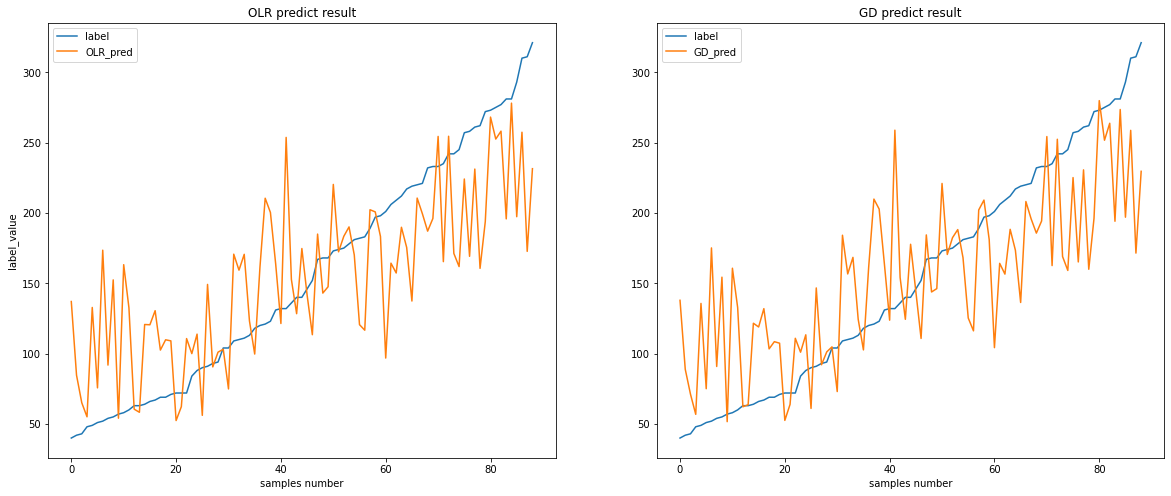

In [19]:
plt.figure(figsize=(20, 8))    #定义画布大小，20是画布的宽，8是画布的高
plt.subplot(121)               #定义子图121表示这组图有1行2列，该子图在第1幅图
plt.plot(range(len(label)),label,label='label')     #画标签折线图，并做好标记
plt.plot(range(len(label)),OLR_pred,label='OLR_pred')  #画预测值折线图，并做好标记
plt.title('OLR predict result')
plt.xlabel('samples number')
plt.ylabel('label_value')
plt.legend()   #显示标记

plt.subplot(122)
plt.plot(range(len(label)),label,label='label')     #画标签折线图，并做好标记
plt.plot(range(len(label)),GD_pred,label='GD_pred')  #画预测值折线图，并做好标记
plt.title('GD predict result')
plt.xlabel('samples number')
plt.legend()   #显示标记
plt.show()    #显示图片

## 三、结果分析

在次实验中首先对线性回归算法原理进行了介绍，其次根据算法的原理实现了普通线性回归算法和基于梯度下降的线性回归算法的功能，最后将实现好的两个算法应用到Scikit-learn库中自带的糖尿病数据集中，并对两个算法的预测结果进行了可视化。从可视化图可以看出，两个算法的预测结果差别不大，结合原理，这两个算法都是在求损失函数的极小值点处的回归系数，只是他们求的方式不同，OLR算法是一步求到最小值点处的回归系数，而GD算法是通过学习率控制下降的梯度分多步进行求极小值点处的回归系数。

## 四、选择SGD算法来实现

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(train_X, train_Y)
pred = model.predict(test_X)

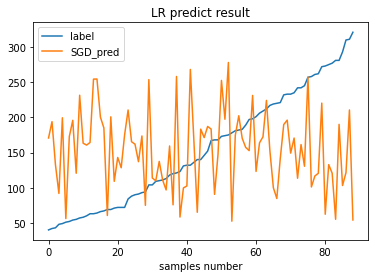

In [22]:
# plt.figure(figsize=(20, 8))    #定义画布大小，20是画布的宽，8是画布的高
# plt.subplot(131)               #定义子图121表示这组图有1行2列，该子图在第1幅图
# plt.plot(range(len(label)),label,label='label')     #画标签折线图，并做好标记
# plt.plot(range(len(label)),OLR_pred,label='OLR_pred')  #画预测值折线图，并做好标记
# plt.title('OLR predict result')
# plt.xlabel('samples number')
# plt.ylabel('label_value')
# plt.legend()   #显示标记

# plt.subplot(132)
# plt.plot(range(len(label)),label,label='label')     #画标签折线图，并做好标记
# plt.plot(range(len(label)),GD_pred,label='GD_pred')  #画预测值折线图，并做好标记
# plt.title('GD predict result')
# plt.xlabel('samples number')
# plt.legend()   #显示标记

# plt.subplot(133)
plt.plot(range(len(label)),label,label='label')     #画标签折线图，并做好标记
plt.plot(range(len(label)),pred,label='SGD_pred')  #画预测值折线图，并做好标记
plt.title('LR predict result')
plt.xlabel('samples number')
plt.legend()   #显示标记
plt.show()    #显示图片